In [1]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import json
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import skimage as sk
import scipy as sci
from scipy.interpolate import RegularGridInterpolator
import skimage.io as io
from scipy import ndimage
from matplotlib.path import Path
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors
import cv2

In [2]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


<>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\Frank\AppData\Local\Temp\ipykernel_21844\3936082645.py:46: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [29]:
def anms(coords, threshold, h):
    r = np.empty((coords.shape[1]))
    for i in range(0, coords.shape[1]):
        currH = h[coords[0, i], coords[1, i]]

        # start = timer()
        filteredY = coords[0][currH < threshold * h[coords[0], coords[1]]]
        filteredX = coords[1][currH < threshold * h[coords[0], coords[1]]]
        filteredCoords = np.array([filteredY, filteredX])

        filteredCoords[0] = np.square((coords[0, i] - filteredCoords[0]))
        filteredCoords[1] = np.square((coords[1, i] - filteredCoords[1]))

        sqDistances = filteredCoords[0] + filteredCoords[1]

        r[i] = float('inf') if len(sqDistances) == 0 else np.min(sqDistances)
        # r[i] = 0 if len(sqDistances) == 0 else np.min(sqDistances)
        # end = timer()
        # print(f"seq: {end-start}")
        # print(i)
        # print()

    return np.argsort(-r)

def findKeypoints(im, anmsThresh, numPoints):
    h, coords = get_harris_corners(im)
    # print(h.shape)
    # print(coords.shape)
    r = anms(coords[:], anmsThresh, h)
    topr = r[:numPoints]
    topCoords = coords[:, topr]
    topCoords = topCoords.swapaxes(0, 1)
    return topCoords

In [34]:
def featureDescriptors(im, coords, descriptorWidth, downSampleRatio, flatten=False):
    # Dont have to worry about edge coords bc of the harrison corner function

    descriptor = np.empty((coords.shape[0], descriptorWidth, descriptorWidth))
    reducedImg = sk.transform.downscale_local_mean(im, downSampleRatio)
    reducedCoords = np.floor_divide(coords, downSampleRatio)
    # print(reducedImg.shape)

    # print(reducedCoords)
    for i in range(coords.shape[0]):
        y, x = reducedCoords[i, 0], reducedCoords[i, 1]
        # print(f"[{y - (descriptorWidth // 2)} : {y + (descriptorWidth - (descriptorWidth // 2))},{x - (descriptorWidth // 2)} : {x + (descriptorWidth - (descriptorWidth // 2))}]")
        # print(y - (descriptorWidth // 2))
        # print(y + (descriptorWidth - (descriptorWidth // 2)))
        # print(x - (descriptorWidth // 2))
        # print(x + (descriptorWidth - (descriptorWidth // 2)))
        descriptor[i] = reducedImg[
            y - (descriptorWidth // 2) : y + (descriptorWidth - (descriptorWidth // 2)),
            x - (descriptorWidth // 2) : x + (descriptorWidth - (descriptorWidth // 2))
        ]

        descriptor[i] = (descriptor[i] - np.mean(descriptor[i])) / np.std(descriptor[i])

    if flatten:
        descriptor = np.reshape(
            descriptor, (descriptor.shape[0], descriptor.shape[1] ** 2)
        )
    return descriptor

In [26]:
# im1 = ndimage.rotate(io.imread("./imgs/testImgs/image.jpg"), 0)
im1 = ndimage.rotate(io.imread("./imgs/houses1.jpg"), 0)
im2 = ndimage.rotate(io.imread("./imgs/houses2.jpg"), 0)

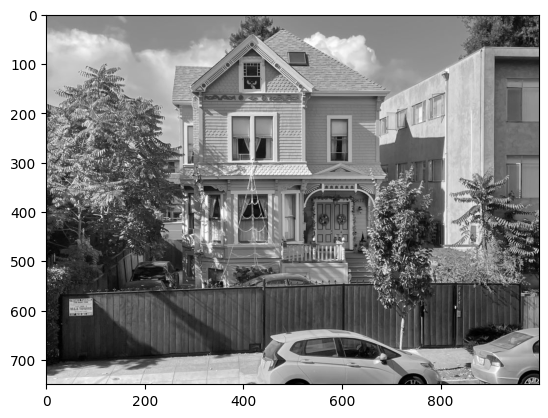

In [122]:
im1Grey = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2Grey = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
plt.imshow(im1Grey, cmap="grey")

In [123]:
im1CoordGrey = findKeypoints(im1Grey, 0.9, 80)
im2CoordGrey = findKeypoints(im2Grey, 0.9, 80)

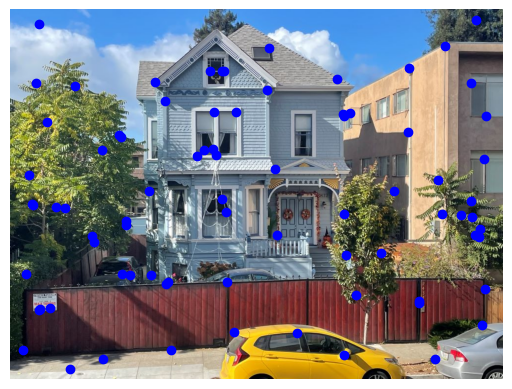

In [83]:
plt.imshow(im1, cmap="grey")
plt.axis("off")

plt.plot(im1CoordGrey[:, 1], im1CoordGrey[:, 0], "bo")
plt.savefig("./resultsPt2/im1ANMS80.jpg", bbox_inches="tight", dpi=1000)

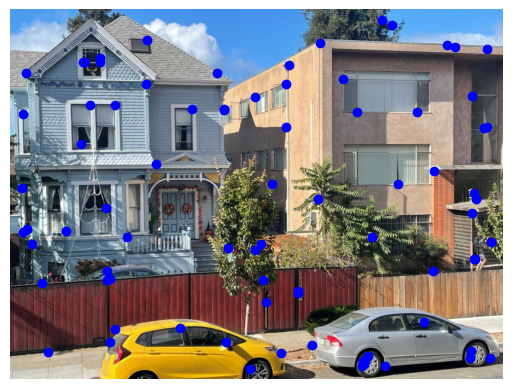

In [ ]:
plt.imshow(im2, cmap="grey")
plt.axis("off")

plt.plot(im2CoordGrey[:, 1], im2CoordGrey[:, 0], "bo")

In [210]:
descriptorim1Color = featureDescriptors(im1Grey, im1CoordGrey, 8, 5, True)
descriptorim2Color = featureDescriptors(im2Grey, im2CoordGrey, 8, 5, True)
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(descriptorim2Color)
distances, indices = nbrs.kneighbors(descriptorim1Color)
selectedPoints = np.argwhere((distances[:, 0] / distances[:, 1]) < 0.85)
print(selectedPoints.T)

# point1 = 57
# point2 = indices[point1, 0]
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].axis("off")
# axs[0, 0].imshow(im1)
# axs[0, 0].plot(im1CoordGrey[point1, 1], im1CoordGrey[point1, 0], "bo")

# axs[0, 1].axis("off")
# axs[0, 1].imshow(descriptorim1Color[point1], cmap="grey")

# axs[1, 0].axis("off")
# axs[1, 0].imshow(im2)
# axs[1, 0].plot(im2CoordGrey[point2, 1], im2CoordGrey[point2, 0], "bo")

# axs[1, 1].axis("off")
# axs[1, 1].imshow(descriptorim2Color[point2], cmap="grey")

# plt.savefig("./resultsPt2/descriptors.jpg", bbox_inches="tight", dpi=1000)

[[ 8 14 15 19 21 22 25 31 35 37 39 41 42 44 46 47 50 52 73 74 76 77]]


In [211]:
keyPointsIm1 = im1CoordGrey[selectedPoints.T][0]
keyPointsIm2 = im2CoordGrey[indices[selectedPoints.T, 0]][0]

shiftedKeypointsIm2 = keyPointsIm2.copy()
shiftedKeypointsIm2[:, 0] = shiftedKeypointsIm2[:, 0] + im1.shape[0]
combinedIm = np.vstack([im1, im2])

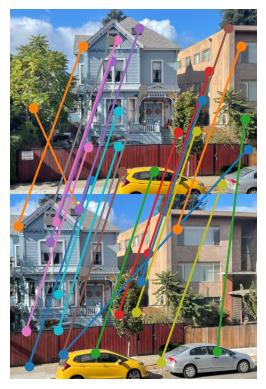

In [213]:
plt.imshow(combinedIm)
plt.axis("off")
plt.plot(
    np.vstack([keyPointsIm1[:, 1], shiftedKeypointsIm2[:, 1]]),
    np.vstack([keyPointsIm1[:, 0], shiftedKeypointsIm2[:, 0]]),
    "-o",
)

In [205]:
def calcH(im1Pt, im2Pt):
    """
    Finds the H transformation matrix using least squares for im1 and im2 points.

    Args:
        im1Pt (Nx3 np.array): im1 correspondances
        im2Pt (Nx3 np.array): im2 correspondances

    Returns:
        h (3x3 np.array): Linear solution of the transformation matrix
    """
    # Initialize A matrix
    A = np.empty((im1Pt.shape[0] * 2, 8))
    b = np.empty((im1Pt.shape[0] * 2, 1))

    # Populate A and b with x and y
    for i in range(im2Pt.shape[0]):
        b[i * 2] = im2Pt[i, 0]
        b[i * 2 + 1] = im2Pt[i, 1]
        A[i * 2] = np.array(
            [
                im1Pt[i, 0],
                im1Pt[i, 1],
                1,
                0,
                0,
                0,
                -im1Pt[i, 0] * im2Pt[i, 0],
                -im1Pt[i, 1] * im2Pt[i, 0],
            ]
        )
        A[i * 2 + 1] = np.array(
            [
                0,
                0,
                0,
                im1Pt[i, 0],
                im1Pt[i, 1],
                1,
                -im1Pt[i, 0] * im2Pt[i, 1],
                -im1Pt[i, 1] * im2Pt[i, 1],
            ]
        )

    # Solve for least squares
    sol = np.linalg.lstsq(A, b)[0]

    h = np.empty((3, 3))

    h[0] = sol[0:3, :].T
    h[1] = sol[3:6, :].T
    h[2, 0:2] = sol[6:, :].T
    h[2, 2] = 1

    # Add bottom row
    return h


def transformPoints(points, H):
    """
    Divides out W term in transformed points

    Args:
        points (Nx2 np.array): x,y coordinates of points
        H (3x3 np.array): Transformation Matrix

    Returns:
        result (Nx2 np.array): Original points transformed by H
    """
    ones = np.ones((points.shape[0], 1))
    homogPoints = np.append(points, ones, 1)
    transformedPoints = np.array([H @ p for p in homogPoints])
    transformedPoints = transformedPoints / transformedPoints[:, 2, None]
    return transformedPoints[:, 0:2]


def ransac(im1Coords, im2Coords, iterations, percentage, inlierTolerance = 0.1):
    # Stops when either iterations are met, or if a percentage of the coords are in the inlier set
    largestInlier = []
    bestH = None
    rng = np.random.default_rng(12345)
    for i in range(iterations):
        rints = rng.integers(low=0, high=len(im1Coords) - 1, size=4)
        # print(rints)
        # print(im1Coords[rints], im2Coords[rints])
        H = calcH(im1Coords[rints], im2Coords[rints])
        guessCoords = transformPoints(im1Coords, H)
        distances = np.linalg.norm(guessCoords - im2Coords, axis = 1)
        # print(distances.shape)
        # print(distances)
        inlier = np.argwhere(distances < inlierTolerance)
        if (inlier.shape[0] > len(largestInlier)):
            largestInlier = list(inlier[:, 0])
            bestH = H
            print(f"{i}: {len(largestInlier)}, ({len(largestInlier)/im1Coords.shape[0]}%)")
            if (len(largestInlier)/im1Coords.shape[0] >= percentage):
                return largestInlier, bestH

    return largestInlier, bestH

In [ ]:
keyPointsIm1.shape

(22, 2)

In [224]:
largestInlier, bestH = ransac(keyPointsIm1, keyPointsIm2, 100, 0.8, 2)

0: 4, (0.18181818181818182%)
1: 7, (0.3181818181818182%)
2: 13, (0.5909090909090909%)
17: 15, (0.6818181818181818%)


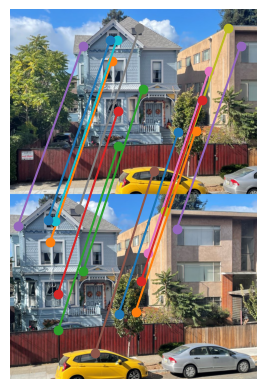

In [226]:
plt.imshow(combinedIm)

plt.axis("off")
plt.plot(
    np.vstack([keyPointsIm1[largestInlier, 1], shiftedKeypointsIm2[largestInlier, 1]]),
    np.vstack([keyPointsIm1[largestInlier, 0], shiftedKeypointsIm2[largestInlier, 0]]),
    "-o",
)
plt.savefig("./resultsPt2/afterRANSAC_2Tol.jpg", bbox_inches="tight", dpi=1000)

In [222]:
im1Pts = np.stack([keyPointsIm1[largestInlier, 1], keyPointsIm1[largestInlier, 0]], axis = 1)
im2Pts = np.stack([keyPointsIm2[largestInlier, 1], keyPointsIm2[largestInlier, 0]], axis = 1)

array([[682, 498],
       [413, 208],
       [538, 324],
       [438, 411],
       [294, 147],
       [582, 657],
       [807, 249],
       [525,  77],
       [883,  74],
       [433, 124],
       [406, 124],
       [753, 493],
       [439, 553],
       [778, 367],
       [935, 148]])